## Maximum-Likelihood Estimation of Recent Shared Ancestry (ERSA)

### Introduction to ERSA

Identifying relationships between individuals using genetic data is fundamental to many applications in genetics, from disease mapping and forensic identification to conservation biology and population studies. While traditional genealogical records can trace relationships back a few generations, genetic data offers the unique ability to detect relationships between individuals who may be unaware of their connection. The challenge lies in developing statistical methods that can accurately infer these relationships from patterns of shared DNA.

**ERSA** (Estimation of Recent Shared Ancestry) is a maximum-likelihood method developed by Huff et al. (2011) that revolutionized our ability to detect distant relationships from genetic data. Traditional relationship inference methods rely on genome-wide averages of allele sharing, which lose statistical power beyond third-degree relatives (approximately first cousins). This limitation arises because the signal of relatedness becomes increasingly diluted across the genome as relationships become more distant.

ERSA addresses these limitations by leveraging the detailed information contained in the **number and lengths of IBD segments** shared between individuals. Rather than averaging genetic similarity across the entire genome, ERSA models the specific pattern of IBD segments, which provides substantially more information about the genealogical relationship.

The key insight is that IBD segments contain rich information about relatedness:
- **Close relatives** share many long segments
- **Distant relatives** share fewer, shorter segments  
- **Individuals with no recent shared ancestry** may still share short segments that descend from distant common ancestors—segments inherited identically by descent from widely shared ancestors deep in the descendant population’s history.

By explicitly modeling these patterns, ERSA can accurately estimate relationships up to approximately eighth-degree relatives and detect relationships as distant as twelfth-degree relatives—a significant improvement over traditional methods.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import factorial
import pandas as pd

### The ERSA Framework

ERSA uses a likelihood ratio test to evaluate whether two individuals share recent ancestry. The framework compares two hypotheses:

1. **Null hypothesis ($H_0$)**: The two individuals are no more related than random members of the population
2. **Alternative hypothesis ($H_a$)**: The two individuals share a specific recent genealogical relationship

The test statistic is based on the ratio of likelihoods under these two models. When the alternative model is significantly more likely, we infer the presence of recent shared ancestry and estimate the degree of relationship.

## Estimation of Recent Ancestry

The ERSA method utilizes the observed IBD segments between two individuals as data. For a pair of individuals, we observe:
- $n$: the total number of IBD segments
- $s = \{\ell_1, \ell_2, ..., \ell_n\}$: the set of segment lengths (in centiMorgans)

The genealogical relationship is characterized by:
- $d$: the total number of meioses separating the individuals
- $a$: the number of common ancestors (1 or 2)

For example:
- Siblings: $d = 2$, $a = 2$ (share both parents)
- Half-siblings: $d = 2$, $a = 1$ (share one parent)
- First cousins: $d = 4$, $a = 2$ (share two grandparents)

> Note: Bonsai refers to the total number of meioses separating the individuals as $m$ and $d$ is the number of degrees.

The likelihood calculation conditions on a minimum detectable segment length $t$, as very short segments cannot be reliably detected by current IBD inference methods. ERSA uses $t = 2.5$ cM, which means:
- Only segments $\geq 2.5$ cM are included in the analysis
- All probability distributions must be conditioned on this threshold
- The number $n$ represents only segments above this threshold

This conditioning is crucial because it affects both the expected number of segments and their length distribution.

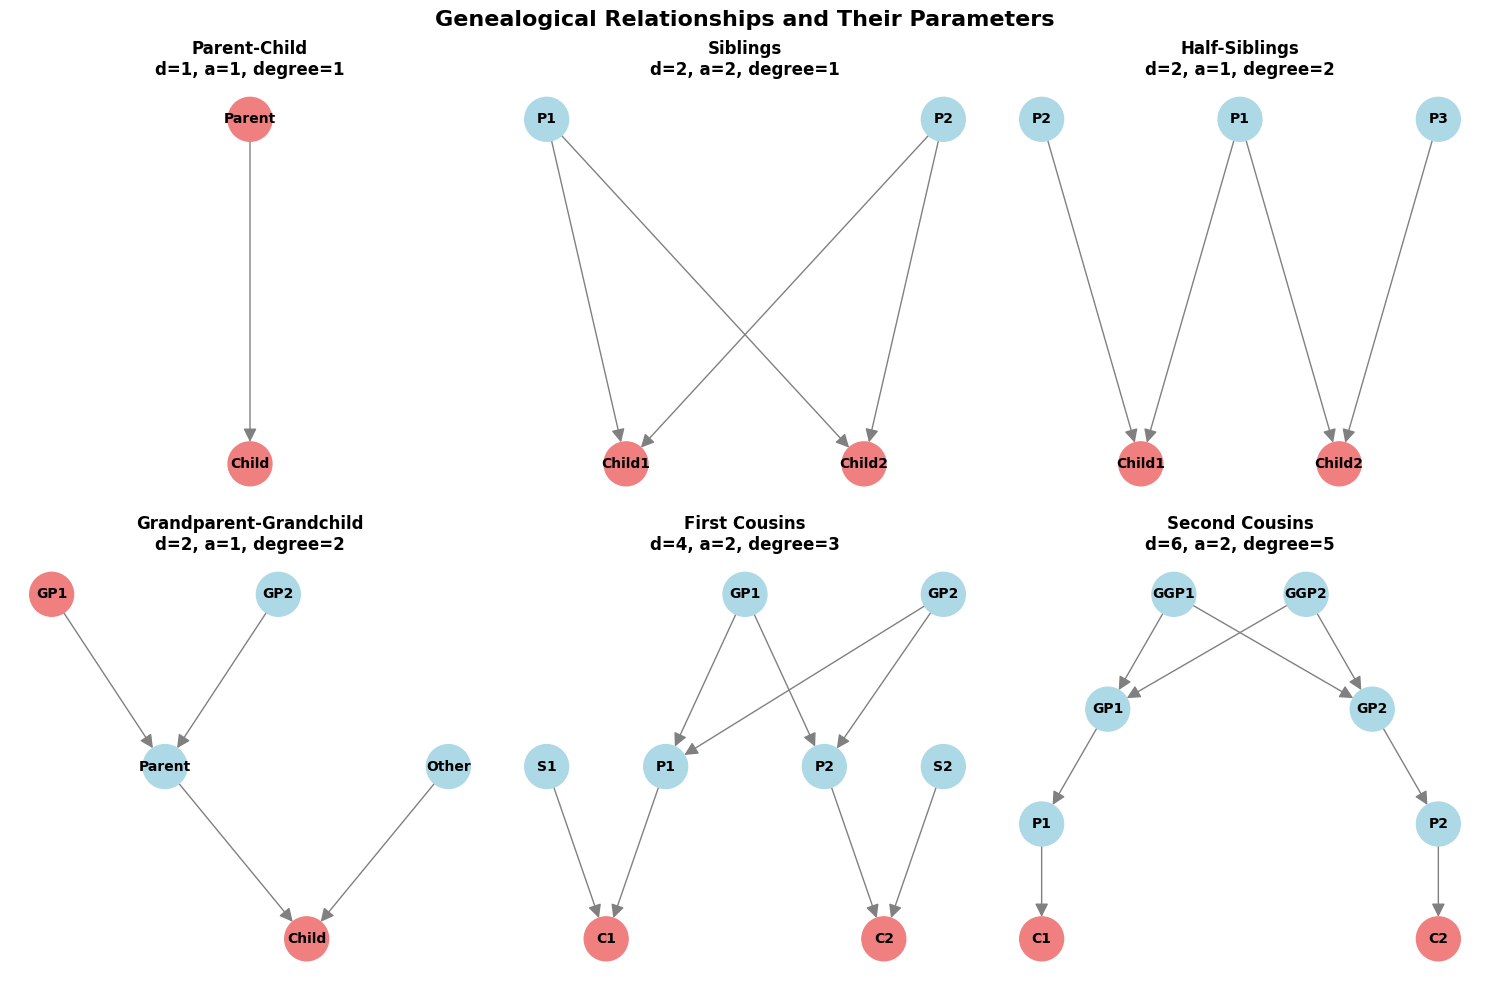


Relationship Summary (not all are visualized):
------------------------------------------------------------
Relationship              d          a          degree    
------------------------------------------------------------
Parent-Child              1          1          1         
Siblings                  2          2          1         
Half-Siblings             2          1          2         
Grandparent-Grandchild    2          1          2         
Aunt/Uncle-Niece/Nephew   3          1          3         
First Cousins             4          2          3         
Half First Cousins        4          1          4         
Second Cousins            6          2          5         
Third Cousins             8          2          7         


In [6]:
# Visualizing relationship parameters with family trees
import networkx as nx

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

def create_relationship_tree(ax, title, relationship_type):
    """Create a family tree diagram for different relationship types"""
    G = nx.DiGraph()
    pos = {}
    
    if relationship_type == "siblings":
        # Siblings share both parents
        G.add_edges_from([("P1", "Child1"), ("P2", "Child1"), 
                         ("P1", "Child2"), ("P2", "Child2")])
        pos = {"P1": (0, 1), "P2": (1, 1), 
               "Child1": (0.2, 0), "Child2": (0.8, 0)}
        highlight = ["Child1", "Child2"]
        info = "d=2, a=2, degree=1"
        
    elif relationship_type == "half_siblings":
        # Half siblings share one parent
        G.add_edges_from([("P1", "Child1"), ("P2", "Child1"), 
                         ("P1", "Child2"), ("P3", "Child2")])
        pos = {"P1": (0.5, 1), "P2": (0, 1), "P3": (1, 1),
               "Child1": (0.25, 0), "Child2": (0.75, 0)}
        highlight = ["Child1", "Child2"]
        info = "d=2, a=1, degree=2"
        
    elif relationship_type == "parent_child":
        # Parent-child relationship
        G.add_edges_from([("Parent", "Child")])
        pos = {"Parent": (0.5, 1), "Child": (0.5, 0)}
        highlight = ["Parent", "Child"]
        info = "d=1, a=1, degree=1"
        
    elif relationship_type == "grandparent":
        # Grandparent-grandchild
        G.add_edges_from([("GP1", "Parent"), ("GP2", "Parent"), 
                         ("Parent", "Child"), ("Other", "Child")])
        pos = {"GP1": (0.3, 2), "GP2": (0.7, 2), 
               "Parent": (0.5, 1), "Other": (1, 1),
               "Child": (0.75, 0)}
        highlight = ["GP1", "Child"]  # or GP2
        info = "d=2, a=1, degree=2"
        
    elif relationship_type == "first_cousins":
        # First cousins
        G.add_edges_from([
            ("GP1", "P1"), ("GP2", "P1"),
            ("GP1", "P2"), ("GP2", "P2"),
            ("P1", "C1"), ("S1", "C1"),
            ("P2", "C2"), ("S2", "C2")
        ])
        pos = {"GP1": (0.5, 3), "GP2": (1, 3),
               "P1": (0.3, 2), "P2": (0.7, 2),
               "S1": (0, 2), "S2": (1, 2),
               "C1": (0.15, 1), "C2": (0.85, 1)}
        highlight = ["C1", "C2"]
        info = "d=4, a=2, degree=3"
        
    elif relationship_type == "second_cousins":
            # Second cousins share two great-grandparents
            G.add_edges_from([
                ("GGP1", "GP1"), ("GGP2", "GP1"),  # Both great-grandparents to GP1
                ("GGP1", "GP2"), ("GGP2", "GP2"),  # Both great-grandparents to GP2
                ("GP1", "P1"), ("GP2", "P2"),
                ("P1", "C1"), ("P2", "C2")
            ])
            pos = {"GGP1": (0.4, 4), "GGP2": (0.6, 4),
                "GP1": (0.3, 3), "GP2": (0.7, 3),
                "P1": (0.2, 2), "P2": (0.8, 2),
                "C1": (0.2, 1), "C2": (0.8, 1)}
            highlight = ["C1", "C2"]
            info = "d=6, a=2, degree=5"
    
    # Draw the graph
    ax.set_title(f"{title}\n{info}", fontsize=12, fontweight='bold')
    
    # Color nodes
    node_colors = ['lightcoral' if node in highlight else 'lightblue' 
                   for node in G.nodes()]
    
    # Draw with hierarchical layout
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=node_colors,
            node_size=1000, font_size=10, font_weight='bold',
            arrows=True, arrowsize=20, edge_color='gray')
    
    ax.axis('off')

# Create different relationship diagrams
relationships = [
    ("Parent-Child", "parent_child"),
    ("Siblings", "siblings"),
    ("Half-Siblings", "half_siblings"),
    ("Grandparent-Grandchild", "grandparent"),
    ("First Cousins", "first_cousins"),
    ("Second Cousins", "second_cousins")
]

for i, (title, rel_type) in enumerate(relationships):
    create_relationship_tree(axes[i], title, rel_type)

plt.suptitle("Genealogical Relationships and Their Parameters", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\nRelationship Summary (not all are visualized):")
print("-" * 60)
print(f"{'Relationship':<25} {'d':<10} {'a':<10} {'degree':<10}")
print("-" * 60)
relationships_data = [
    ("Parent-Child", 1, 1, 1),
    ("Siblings", 2, 2, 1),
    ("Half-Siblings", 2, 1, 2),
    ("Grandparent-Grandchild", 2, 1, 2),
    ("Aunt/Uncle-Niece/Nephew", 3, 1, 3),
    ("First Cousins", 4, 2, 3),
    ("Half First Cousins", 4, 1, 4),
    ("Second Cousins", 6, 2, 5),
    ("Third Cousins", 8, 2, 7)
]
for rel, d, a, deg in relationships_data:
    print(f"{rel:<25} {d:<10} {a:<10} {deg:<10}")

## The Null Hypothesis Model

Under the null hypothesis, the two individuals share no recent genealogical relationship that would distinguish them from random pairs in the population. Any IBD segments they share arise from the baseline level of sharing observed between population members.

This baseline sharing reflects segments inherited from common ancestors in the deep past—ancestors whose descendants now comprise a substantial fraction of the population. When an ancestor lived many generations ago (perhaps 20+ generations), their genetic material has been passed down through so many different lineages that many present-day individuals carry identical segments from that ancestor.

ERSA models the null hypothesis using empirical distributions derived from the population. The likelihood under the null hypothesis is:

$$L_P(n, s|t) = N_P(n|t) \cdot S_P(s|t) \tag{1}$$

where:
- $N_P(n|t)$ is the probability of observing $n$ segments with length $\geq t$ between a random pair from the population
- $S_P(s|t)$ is the probability of observing the specific set of segment lengths $s$, given that all segments have length $\geq t$

The key insight is that the null model represents the **expected IBD sharing between two individuals drawn at random from the population**, capturing the background level of IBD that arises from ancestors shared by many population members rather than recent, genealogically traceable relationships.

### Modeling the Number of Segments

Having introduced $N_P(n|t)$ in equation (1), we now specify how this probability is modeled. The number of background segments shared between two individuals follows a Poisson distribution:

$$N_P(n|t) = \frac{\eta^n e^{-\eta}}{n!} \tag{1a}$$

where $\eta$ is the expected (mean) number of segments with length $\geq t$ observed between random pairs in the population.

**Understanding the Poisson Distribution:**

This formula gives us the probability of observing exactly $n$ segments. Key components:
- $\eta$: the average number of segments shared between random pairs in the population
- $e \approx 2.718$: Euler's number (a mathematical constant)
- $n!$: factorial of $n$ (for example, $3! = 3 \times 2 \times 1 = 6$)
- $n$: the specific number of segments we're calculating the probability for

The Poisson distribution is ideal for modeling "rare events" - it describes the probability of observing a certain number of events when:
- Events occur independently
- Events occur at a constant average rate
- The probability of two events occurring at exactly the same position is negligible

>**In Python, we model the Poisson distribution as follows:**
>
>```python
>poisson_probs = stats.poisson.pmf(n_segments, eta)
>```
>
>This computes $N_P(n|t) = \frac{\eta^n e^{-\eta}}{n!}$ where:
>- `eta` is $\eta$, the mean number of segments for the population
>- `n_segments` is $n$, the number of segments we want to calculate the probability for
>- The function returns the probability of observing $n$ segments given mean $\eta$

The Poisson distribution describes the graph shape. The following graph is a reproduction of Figure 2B from the ERSA paper.

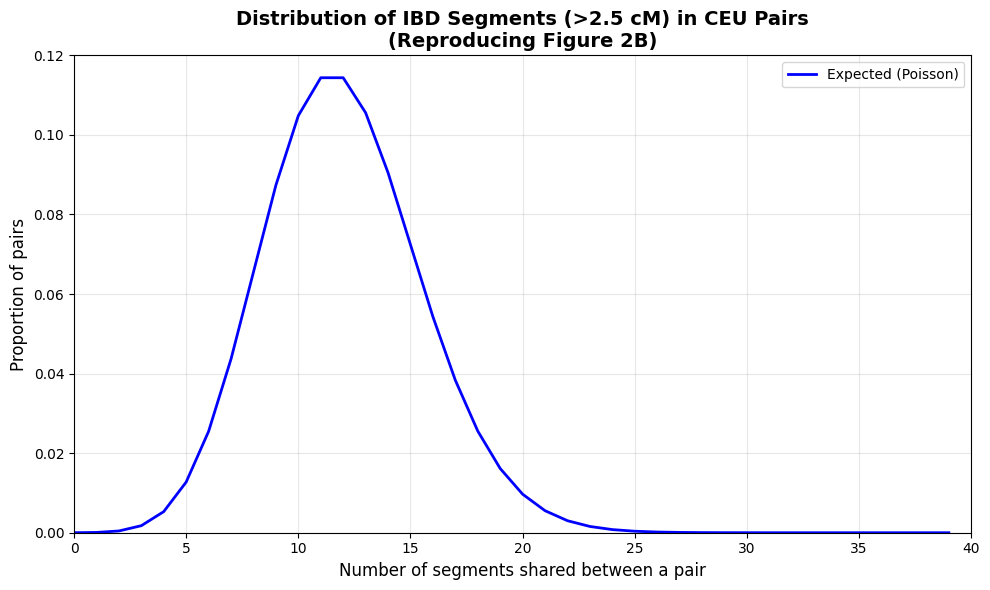

For Poisson with η = 12:
Peak (mode) at n = 12
Probability at peak = 0.114
Mean = 12
Variance = 12
Standard deviation = 3.46


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Based on Figure 2B from ERSA paper
eta = 12  # Mean number of segments for CEU population

# Generate the Poisson distribution
n_segments = np.arange(0, 40)
poisson_probs = stats.poisson.pmf(n_segments, eta)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the expected (Poisson) distribution
ax.plot(n_segments, poisson_probs, 'b-', linewidth=2, label='Expected (Poisson)')

# You could overlay observed data if you have it
# ax.plot(n_segments, observed_data, 'k-', linewidth=2, label='Observed')

ax.set_xlabel('Number of segments shared between a pair', fontsize=12)
ax.set_ylabel('Proportion of pairs', fontsize=12)
ax.set_title('Distribution of IBD Segments (>2.5 cM) in CEU Pairs\n(Reproducing ERSA Figure 2B)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 40)
ax.set_ylim(0, 0.12)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Print some key values
print(f"For Poisson with η = {eta}:")
print(f"Peak (mode) at n = {np.argmax(poisson_probs)}")
print(f"Probability at peak = {np.max(poisson_probs):.3f}")
print(f"Mean = {eta}")
print(f"Variance = {eta}")
print(f"Standard deviation = {np.sqrt(eta):.2f}")

### Understanding How η Shapes the Distribution

The Poisson distribution's shape is entirely determined by its single parameter, η (eta). For η = 12, we see a bell-shaped distribution centered around 12 segments. This tells us that:

- Most random pairs in this sample share around 10-14 segments
- Very few pairs share fewer than 5 or more than 20 segments  

But what happens with different values of η? The Poisson distribution changes shape dramatically depending on this parameter.

Let's visualize how different η values create different distribution shapes:

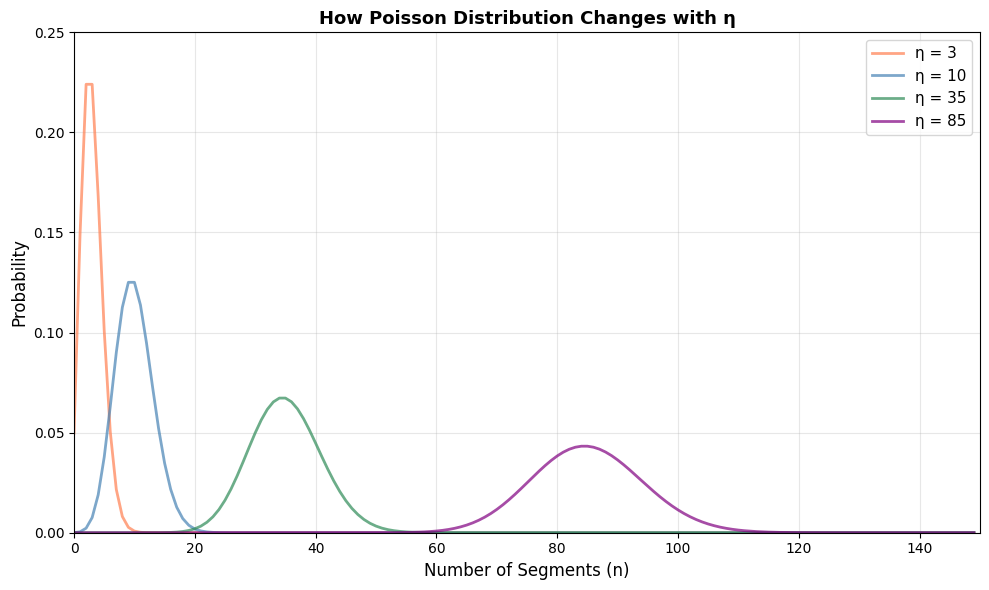

In [21]:
# Compare different values of η to show how shape changes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_title('How Poisson Distribution Changes with η', fontsize=13, fontweight='bold')
eta_values = [3, 10, 35, 85]
colors = ['coral', 'steelblue', 'seagreen', 'purple']
n_range = np.arange(0, 150)  # Extended range for larger η

for eta_val, color in zip(eta_values, colors):
    probs = stats.poisson.pmf(n_range, eta_val)
    # Use lines only (no markers) for cleaner visualization
    ax.plot(n_range, probs, '-', color=color, alpha=0.7, 
            linewidth=2, label=f'η = {eta_val}')

ax.set_xlabel('Number of Segments (n)', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.25)  # Set y-limit to see all distributions clearly

plt.tight_layout()
plt.show()

### From the Likelihood to Its Components

Recall the null hypothesis in equation (1):

$$L_P(n, s|t) = N_P(n|t) \cdot S_P(s|t) \tag{1}$$

We examined how one component is modeled:
$$N_P(n|t) = \frac{\eta^n e^{-\eta}}{n!} \tag{1a}$$

We've saw how $N_P(n|t)$ follows a Poisson distribution with mean $\eta$ estimated from the population. 

Now we turn to the second component: modeling the lengths of the observed segments.

$$S_P(s|t)$$

$S_P(s|t)$ is the probability of observing the specific set of segment lengths $s$.

### Modeling Segment Lengths

The probability of observing the set of segment lengths is computed as the product of individual segment probabilities, assuming independence:

$$S_P(s|t) = \prod_{i \in s} F_P(i|t) \tag{2}$$

To understand this notation: if $s = \{\ell_1, \ell_2, ..., \ell_n\}$ is our set of observed segment lengths, then:

$$S_P(\{\ell_1, \ell_2, ..., \ell_n\}|t) = F_P(\ell_1|t) \times F_P(\ell_2|t) \times ... \times F_P(\ell_n|t)$$

where $F_P(\ell_i|t)$ is the probability density for observing a segment of length $\ell_i$ in the population, conditional on $\ell_i \geq t$.

For example, if we observe three segments with lengths $s = \{3.5, 7.2, 4.1\}$ cM, then:
$$S_P(\{3.5, 7.2, 4.1\}|t) = F_P(3.5|t) \times F_P(7.2|t) \times F_P(4.1|t)$$

This independence assumption is reasonable for segments arising from the population background, as these segments typically trace back to different common ancestors in the distant past.

### Understanding the Independence Assumption

The independence assumption means that for population background segments, each segment's length is independent of the others. This is reasonable because:

**Background segments come from different ancestors in different generations:**
- If two random CEU individuals share 12 segments (the population average)
- Each segment likely traces back to a *different* common ancestor
- These ancestors lived at various times in the distant past (20+ generations ago)
- The inheritance of one segment doesn't affect the others

**Example scenario:**
Consider two individuals sharing three background segments:
- **Segment 1 (3.5 cM)**: Inherited from a common ancestor 30 generations ago
- **Segment 2 (7.2 cM)**: From a completely different ancestor 25 generations ago
- **Segment 3 (4.1 cM)**: From yet another ancestor 40 generations ago

Since these are independent genealogical events—different ancestors, different inheritance paths, different generations—we can treat the segment lengths as independent random variables and multiply their probabilities.

**Contrast with recent ancestry:**
This differs from segments shared through recent ancestry, where multiple segments often come from the *same* recent ancestor (like a shared grandparent) and travel through the same inheritance path, making their lengths potentially correlated.

### The Exponential Distribution for Segment Lengths

Considering

$$S_P(s|t) = \prod_{i \in s} F_P(i|t) \tag{2}$$

Under random mating with complete ascertainment of shared segments, segment lengths theoretically follow a geometric distribution. However, ERSA uses an exponential distribution as a continuous approximation:

$$F_P(i|t) = \frac{e^{-(i-t)/\mu}}{\mu} \tag{3}$$

where:
- $i$ is the segment length in centiMorgans
- $t = 2.5$ cM is the minimum detectable segment length
- $\mu = 3.12$ cM is the mean segment length in the population (for segments between $t$ and $h$)
- The distribution is shifted by $t$ since we only observe segments $\geq t$

**Key Implementation Choices:**

1. **Minimum threshold $t = 2.5$ cM**: Based on Germline's false-negative rate of ~1% for segments of this length. This threshold:
   - Maximizes usable data (includes most real segments)
   - Ensures the exponential approximation remains valid
   - Maintains reliable IBD detection

2. **Maximum threshold $h = 10$ cM**: Segments longer than 10 cM are excluded when estimating $\mu$ because:
   - They likely represent recent shared ancestry rather than background
   - Including them would contaminate the null distribution
   - They violate the random mating assumption

3. **Mean segment length $\mu = 3.12$ cM**: Estimated from CEU segments with lengths between 2.5 and 10 cM

>**In Python, we model the exponential distribution (equation 3) as follows:**
>
>```python
>def exponential_pdf(length, mu, t=2.5):
>    """Probability density for segment length under null hypothesis"""
>    if length >= t:
>        return np.exp(-(length - t)/mu) / mu
>    else:
>        return 0  # No probability for segments shorter than t
>```
>where `mu` is $\mu$, the mean segment length.
>
>**Equation 2 would then be modeled as follows:**
>
>```python
># For segments with lengths l_1, l_2, l_3, ...
>S_P = exponential_pdf(l_1, mu, t) * exponential_pdf(l_2, mu, t) * exponential_pdf(l_3, mu, t) * ...
>```
>This computes $S_P(s|t) = \prod_{i \in s} F_P(i|t)$ by multiplying the individual segment probabilities.

> ### 📊 **Mathematical Note: Geometric to Exponential Approximation**
>
> **What the paper means:**
> 
> Under ideal conditions (random mating, detecting all shared segments), the length of IBD segments follows a **geometric distribution** - a discrete distribution that counts the number of generations until a recombination event breaks the segment.
>
> **The geometric distribution:**
> - Segments are broken by recombination events during meiosis
> - Each generation, there's a probability that a recombination occurs
> - The segment length (in genetic distance) depends on how many generations pass before a break
> - This creates a discrete, step-like distribution
>
> **Why use exponential instead?**
> - The exponential distribution is the **continuous version** of the geometric distribution
> - Since we measure segments in centiMorgans (a continuous scale), not discrete generations, the exponential is more natural
> - Mathematically simpler to work with (easier integration, derivatives, etc.)
> - When dealing with many generations and recombination events, the discrete steps become negligible
>
> **The approximation is valid because:**
> - We're looking at segments that have passed through many meioses
> - The genetic distance (cM) is effectively continuous at this scale
> - The exponential closely matches the geometric for the parameter ranges we observe
>
> **For very recent relationships (e.g., parent-child, siblings):**
> - The geometric distribution might be more accurate since fewer meioses are involved
> - In Python, you would use `scipy.stats.geom` for the geometric distribution:
>   ```python
>   from scipy.stats import geom
>   # For a segment with probability p of breaking each generation
>   geom.pmf(k, p)  # Probability of breaking at generation k
>   ```
>   where:
>   - `p` = probability of recombination breaking the segment per generation (the proportion format of the cM value)
>   - `k` = generation number when the segment breaks
>   
>   For example, a 5 cM segment has a 5% probability of recombining each generation, so `p = 0.05`
>   **This gives us probability over GENERATIONS, not segment LENGTH, we would need to do some conversions.**
>   If we wanted to use the geometric distribution for ERSA's equations, we'd need to sum over all possible generation values
> - However, ERSA still uses exponential even for close relatives because the continuous approximation.
>
> This is similar to approximating a binomial distribution with a normal distribution—we use the continuous version for mathematical convenience when the discrete steps are small relative to the scale we're working with.

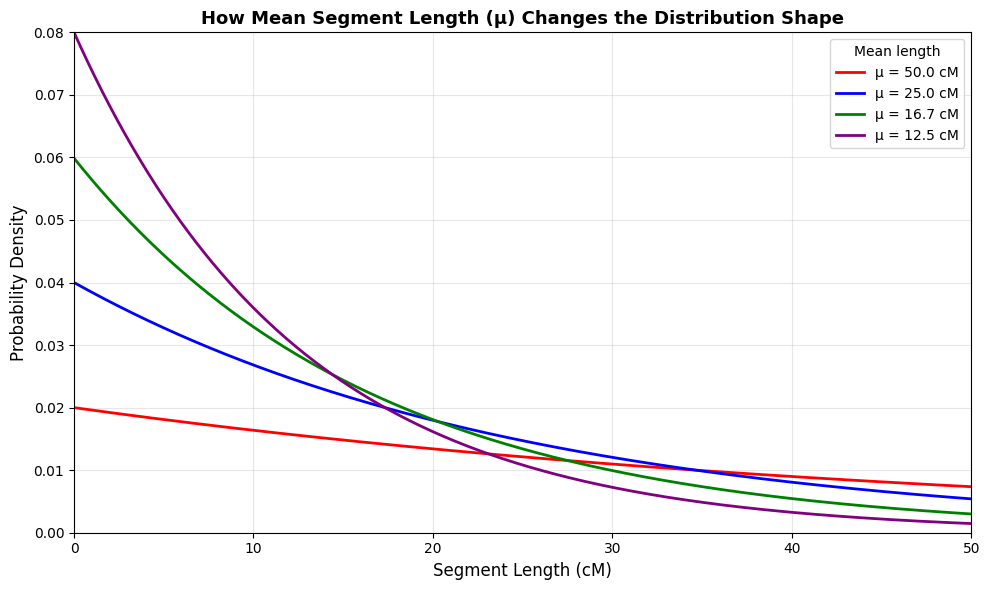

In [37]:
# Understanding how μ (mean segment length) changes the exponential distribution
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Different values of μ (mean segment length)
mu_values = [50, 25, 16.7, 12.5]  # These correspond to d = 2, 4, 6, 8
colors = ['red', 'blue', 'green', 'purple']
labels = [f'μ = {mu:.1f} cM' for mu in mu_values]

x = np.linspace(0, 50, 1000)

for mu, color, label in zip(mu_values, colors, labels):
    y = (1/mu) * np.exp(-x/mu)
    ax.plot(x, y, color=color, linewidth=2, label=label)

ax.set_xlabel('Segment Length (cM)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('How Mean Segment Length (μ) Changes the Distribution Shape', fontsize=13, fontweight='bold')
ax.set_xlim(0, 50)
ax.set_ylim(0, 0.08)
ax.legend(loc='upper right', title='Mean length')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary: The Complete Null Model

Recall the null hypothesis likelihood from equation (1):

$$L_P(n, s|t) = N_P(n|t) \cdot S_P(s|t) \tag{1}$$

We have now fully specified both components:

1. **Number of segments**: $N_P(n|t) = \frac{\eta^n e^{-\eta}}{n!}$ where η is estimated from the population (equation 1a)

2. **Segment lengths**: $S_P(s|t) = \prod_{i \in s} F_P(i|t)$ where $F_P(i|t) = \frac{e^{-(i-t)/\mu}}{\mu}$ (equations 2 & 3)

Together, these fully specify $L_P(n, s|t)$, the likelihood of observing any pattern of IBD segments under the hypothesis of no recent shared ancestry.

**Key takeaway**: The null model characterizes the baseline IBD sharing expected between individuals with no recent genealogical relationship. This baseline reflects the complex genealogical connections that exist at the population level from ancestors in the distant past.

This null model serves as the baseline for comparison. In the next section, we'll develop the alternative hypothesis model for individuals who DO share recent ancestry, allowing ERSA to distinguish between background IBD sharing and recent genealogical relationships.